In [85]:
import os
import numpy as np
import math
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch
img_save_path = './conditionalGAN/images/'
os.makedirs(img_save_path, exist_ok=True)

n_epochs = 200 # number of epochs of training
batch_size = 64 # size of the batches
lr = 0.0002 # learning rate
beta1 = 0.5 # decay of the first order mmomentum of gradient
beta2 = 0.999 # decay of second order momentum of gradient
latent_dim = 100 # dim of the latent space
n_classes = 10 # number of classes for dataset
image_size = 28 # size of each image dimension
channels = 1 # number of image channels
sample_interval = 200 # interval between image sampling
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight,0.0,0.02)
    elif classname.find('BatchNorm2d')!=-1:
        torch.nn.init.normal(m.weight,1.0,0.02)
        torch.nn.init.constant(m.bias,0.0)
        
def idx2onehot(idx, n):
    assert torch.max(idx).item() < n and idx.dim() == 1
    idx2dim = idx.view(-1,1) # change from 1-dim tensor to 2-dim tensor
    onehot = torch.zeros(idx2dim.size(0),n).scatter_(1,idx2dim,1)

    return onehot


    
class Generator(nn.Module):
    # initializers
    def __init__(self):
        super().__init__()
        self.fc1_1 = nn.Linear(latent_dim,256)
        self.fc1_1_bn = nn.BatchNorm1d(256)
        self.fc1_2 = nn.Linear(10, 256)
        self.fc1_2_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(512,512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512,1024)
        self.fc3_bn = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024,image_size**2)
    
    # forward method
    def forward(self, z, y):
        x1 = F.relu(self.fc1_1_bn(self.fc1_1(z)))
        x2 = F.relu(self.fc1_2_bn(self.fc1_2(y)))
        x = torch.cat([x1, x2], dim = 1)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = torch.tanh(self.fc4(x))
        return x
    
class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super().__init__()
        self.fc1_1 = nn.Linear(image_size**2, 1024)
        self.fc1_2 = nn.Linear(10, 1024)
        self.fc2 = nn.Linear(2048, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512,256)
        self.fc3_bn = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)
        
        # forward method
    def forward(self, input, y):
        x1 = F.leaky_relu(self.fc1_1(input), 0.2)
        x2 = F.leaky_relu(self.fc1_2(y),0.2)
        x = torch.cat([x1, x2], dim = 1)
        x = F.leaky_relu(self.fc2_bn(self.fc2(x)),0.2)
        x = F.leaky_relu(self.fc3_bn(self.fc3(x)),0.2)
        x = torch.sigmoid(self.fc4(x))
        return x
        
# Loss function
loss = torch.nn.BCELoss()

# Initialize Generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Move model to the corresponding device
generator.to(device)
discriminator.to(device)

# Initialize weights
#generator.apply(weights_init_normal)
#discriminator.apply(weights_init_normal)

data_save_path = './conditionalGAN/data/'
os.makedirs(data_save_path, exist_ok = True)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*channels,[0.5]*channels)
])
#
dataset = datasets.MNIST(root = data_save_path, train = True, download = True, transform=transform)


dataloader = DataLoader(dataset,batch_size = batch_size,shuffle=True,drop_last = True)
print("the data is OK")


the data is OK


In [86]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(),lr = 10*lr, betas = (beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(),lr = lr, betas = (beta1, beta2))
def reset_grad():
    optimizer_D.zero_grad()
    optimizer_G.zero_grad()

In [75]:
def sample_image(n_row, n_col,epoch):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = torch.randn(n_row*n_col, latent_dim).to(device)
    # Get labels ranging from 0 to n_classes for n rows
    labels = torch.Tensor([num for _ in range(n_col) for num in range(n_row)]).type(torch.LongTensor)
    labels = idx2onehot(labels,n_classes).to(device)
    gen_imgs = generator(z, labels).view(z.size(0),channels,image_size,image_size) # reshape the output of the generator
    save_image((((gen_imgs+1)/2).round()-0.5)*2, os.path.join(img_save_path,'{}.png'.format(epoch)),nrow=n_row, normalize=True)
    

In [ ]:
total_step = len(dataloader)
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(dataloader):
        images = ((((images.view(images.size(0), -1)+1)/2).round()-0.5)*2).to(device)
        
        #images = images.view(images.size(0), -1).round().to(device)

        real_labels = torch.ones(batch_size,1).to(device)
        fake_labels = torch.zeros(batch_size,1).to(device)
        
        # Configure labels
        
        labels_onehot = idx2onehot(labels,n_classes).to(device)

        
        # =============================================
        #
        #  Training Discriminator 
        #
        # =============================================
        
        outputs = discriminator(images,labels_onehot)
        d_loss_real = loss(outputs, real_labels)
        real_score = outputs # just for the purpose of tracking training progress
        
        z = torch.randn(batch_size, latent_dim).to(device)
        label_z = idx2onehot(torch.randint(n_classes,(batch_size,)),n_classes).to(device)
        
        fake_images = generator(z,label_z).detach()
        outputs = discriminator(fake_images,label_z)
        d_loss_fake = loss(outputs, fake_labels)
        fake_score = outputs # just for the purpose of tracking training progress
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad() # reset stored gradients
        d_loss.backward()
        optimizer_D.step()
        
        
        # =============================================
        #
        #  Training Generator
        #
        # ============================================
        
        z = torch.randn(batch_size, latent_dim).to(device)
        label_z = idx2onehot(torch.randint(n_classes,(batch_size,)),n_classes).to(device)

        fake_images = generator(z,label_z)
        outputs = discriminator(fake_images,label_z)
        g_loss = loss(outputs, real_labels)
        reset_grad()
        g_loss.backward()
        optimizer_G.step()
    
        if (i+1) % sample_interval == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss:{:.2f}, D(x):{:.2f}, D(G(z)): {:.2f}'.format(epoch, n_epochs, i+1, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

    sample_image(n_row=10,n_col=10,epoch=epoch)

Epoch [0/200], Step [200/937], d_loss: 0.6554, g_loss:1.34, D(x):0.74, D(G(z)): 0.30
Epoch [0/200], Step [400/937], d_loss: 1.0590, g_loss:1.31, D(x):0.57, D(G(z)): 0.35
Epoch [0/200], Step [600/937], d_loss: 1.1792, g_loss:1.00, D(x):0.60, D(G(z)): 0.46
Epoch [0/200], Step [800/937], d_loss: 0.9952, g_loss:1.23, D(x):0.57, D(G(z)): 0.33
Epoch [1/200], Step [200/937], d_loss: 1.1205, g_loss:1.39, D(x):0.58, D(G(z)): 0.41
Epoch [1/200], Step [400/937], d_loss: 0.8210, g_loss:1.41, D(x):0.74, D(G(z)): 0.40
Epoch [1/200], Step [600/937], d_loss: 0.3409, g_loss:2.24, D(x):0.87, D(G(z)): 0.18
Epoch [1/200], Step [800/937], d_loss: 0.8184, g_loss:1.48, D(x):0.68, D(G(z)): 0.33
Epoch [2/200], Step [200/937], d_loss: 0.6229, g_loss:1.57, D(x):0.77, D(G(z)): 0.27
Epoch [2/200], Step [400/937], d_loss: 0.6855, g_loss:1.42, D(x):0.83, D(G(z)): 0.37
Epoch [2/200], Step [600/937], d_loss: 0.5985, g_loss:2.10, D(x):0.65, D(G(z)): 0.10
Epoch [2/200], Step [800/937], d_loss: 0.3058, g_loss:2.77, D(x):

Epoch [24/200], Step [200/937], d_loss: 0.0031, g_loss:6.58, D(x):1.00, D(G(z)): 0.00
Epoch [24/200], Step [400/937], d_loss: 0.0015, g_loss:7.48, D(x):1.00, D(G(z)): 0.00
Epoch [24/200], Step [600/937], d_loss: 0.0014, g_loss:8.52, D(x):1.00, D(G(z)): 0.00
Epoch [24/200], Step [800/937], d_loss: 0.0010, g_loss:8.50, D(x):1.00, D(G(z)): 0.00
Epoch [25/200], Step [200/937], d_loss: 0.0006, g_loss:8.60, D(x):1.00, D(G(z)): 0.00
Epoch [25/200], Step [400/937], d_loss: 0.0006, g_loss:8.88, D(x):1.00, D(G(z)): 0.00
Epoch [25/200], Step [600/937], d_loss: 0.0004, g_loss:8.67, D(x):1.00, D(G(z)): 0.00
Epoch [25/200], Step [800/937], d_loss: 0.0006, g_loss:8.83, D(x):1.00, D(G(z)): 0.00
Epoch [26/200], Step [200/937], d_loss: 0.0005, g_loss:8.12, D(x):1.00, D(G(z)): 0.00
Epoch [26/200], Step [400/937], d_loss: 0.0002, g_loss:9.19, D(x):1.00, D(G(z)): 0.00
Epoch [26/200], Step [600/937], d_loss: 0.0011, g_loss:8.43, D(x):1.00, D(G(z)): 0.00
Epoch [26/200], Step [800/937], d_loss: 0.0006, g_loss

tensor(0.)


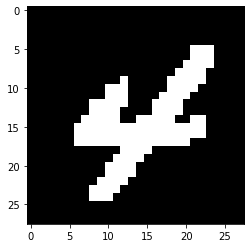

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(dataloader):
        print(torch.min(images))
        shape = images.size()
        images = ((((((images.view(images.size(0), -1)+1)/2).round()-0.5)*2)/2+0.5)*255).view(*shape)
        plt.imshow(images[0].squeeze().numpy(),cmap='gray')
        break
    break